# Optimal Resource Allocation in Healthcare
### Some code copied from the SIR Gillespie algorithm by Luca Sbano (Theory & Implementation) and Steffen Bauer (Implementation & Jupyter)
***

__Definitions:__
<br>

|Variable | Meaning            |
|---------|--------------------|
|$D_1^1$: | disease 1, stage 1 |
|$D_1^2$: | disease 1, stage 2 |
|$D_2^1$: | disease 2, stage 1 |
|$D_2^2$: | disease 2, stage 2 |
|$I^1$:   | stage 1 treatment  |
|$I^2$:   | stage 2 treatment  |

__Reactions:__
<br>
$$
\begin{align}
    \empty &\rightarrow^{\lambda_1} D_1^1\\
    \empty &\rightarrow^{\lambda_2} D_2^1\\
    D_1^1 &\rightarrow^{r_1^1} D_1^2\\
    D_2^1 &\rightarrow^{r_2^1} D_2^2\\
    D_1^2 &\rightarrow^{r_1^2} \empty\\
    D_2^2 &\rightarrow^{r_2^2} \empty\\
    \empty &\rightarrow^{i^1} I^1\\
    \empty &\rightarrow^{i^2} I^2\\
    D_1^1 + I^1 &\rightarrow^{p_1^1} \empty\\
    D_2^1 + I^1 &\rightarrow^{p_2^1} \empty\\
    D_1^2 + I^2 &\rightarrow^{p_1^2} \empty\\
    D_2^2 + I^2 &\rightarrow^{p_2^2} \empty\\
\end{align}
$$

# Propensities used

We have two options for modelling the influx of patients with stage 1 diseases into the model. We could have a total population size and a rate at individuals are diagnosed with the disease, and decrease the population size by one each time this happens. To reduce complexity, we will have a constant 'healthy' population size, and will model this influx as a Poisson process. Hence each of these rules have a constant propensity $\lambda_i$.

## Implementation

First load some libraries:

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from ipywidgets import interact
from IPython.display import display

Define the algorithm [above](#Algorithm) as a function (later used for interactivity):

In [52]:
def gillespie(lambda1   = 20, 
              lambda2   = 20, 
              r1_1      = 10, 
              r1_2      = 1,
              r2_1      = 10,
              r2_2      = 1,
              i1        = 15,
              i2        = 10,
              I1_ratio  = 0.5, 
              I2_ratio  = 0.5,
              plot_bool = True,
              max_treatments = 1
             ):
    
    T     = 100.0           #        float; maximum elapsed time 
    t     = 0.0             #        float; start time
    
    D1_1    = 0             #        int;   initial disease 1 stage 1
    D2_1    = 0             #        int;   initial disease 1 stage 2
    D1_2    = 0             #        int;   initial disease 2 stage 1
    D2_2    = 0             #        int;   initial disease 2 stage 2
    I1      = 0             #        int;   initial stage 1 treatments
    I2      = 0             #        int;   initial stage 2 treatments
    deaths  = 0             #        int;   number of deaths
    cured   = 0             #        int;   number of people cured
    time_in_stage_1 = 0     #        float; patient days spent in stage 1
    time_in_stage_2 = 0     #        float; patient days spent in stage 2
    days_alive = 0          #        float; days alive after diagnosis

    #ensure that is is a ratio
    I1_ratio = I1_ratio / (I1_ratio + I2_ratio)
    I2_ratio = 1 - I1_ratio

    # Initialize results list
    MAXITER       = 20000
    SIR_data      = np.zeros((MAXITER, 12))

    it = 0
    # Main loop
    while t < T and it < MAXITER - 1:
        it += 1

        # Calculate propensities
        propensities = [
            lambda1,
            lambda2,
            r1_1 * D1_1,
            r1_2 * D1_2,
            r2_1 * D2_1,
            r2_2 * D2_2,
            i1,
            i2,
            I1_ratio * 1000 * D1_1 * I1,
            (1 - I1_ratio) * 1000 * D1_2 * I1,
            I2_ratio * 1000 * D2_1 * I2,
            (1 - I2_ratio) * 1000 * D2_2 * I2
        ]

        # when there are no priority patients left
        if I1_ratio == 0 and D1_2 == 0:
            propensities[8] = 1000 * D1_1 * I1
        if I1_ratio == 1 and D1_1 == 0:
            propensities[9] = 1000 * D1_2 * I1
        if I1_ratio == 0 and D2_2 == 0:
            propensities[10] = 1000 * D2_1 * I2
        if I1_ratio == 1 and D2_1 == 0:
            propensities[11] = 1000 * D2_2 * I2
        
        R0 = sum(propensities)

        # First uniformily distributed ranmdom number
        r_1 = np.random.uniform(0.0, 1.0)
        # Time increment
        dt  = -np.log(r_1) / R0
        t   = t + dt

        time_in_stage_1 += dt * (D1_1 + D1_2)
        time_in_stage_2 += dt * (D2_1 + D2_2)
        days_alive += dt * (D1_1 + D1_2 + D2_1 + D2_2 + cured)
        #Second uniformily distributed ranmdom number
        r_2 = R0 * np.random.uniform(0.0, 1.0)
    
        #Choice of the reaction according to the probabilities
        if r_2 < propensities[0]:
            D1_1 += 1
        if r_2 >= propensities[0] and r_2 < sum(propensities[0:2]):
            D1_2 += 1
        if r_2 >= sum(propensities[0:2]) and r_2 < sum(propensities[0:3]):
            D1_1 -= 1
            D2_1 += 1
        if r_2 >= sum(propensities[0:3]) and r_2 < sum(propensities[0:4]):
            D1_2 -= 1
            D2_2 += 1
        if r_2 >= sum(propensities[0:4]) and r_2 < sum(propensities[0:5]):
            D2_1 -= 1
            deaths += 1
        if r_2 >= sum(propensities[0:5]) and r_2 < sum(propensities[0:6]):
            D2_2 -= 1
            deaths += 1
        if r_2 >= sum(propensities[0:6]) and r_2 < sum(propensities[0:7]):
            I1 = min(I1 + 1, max_treatments)
        if r_2 >= sum(propensities[0:7]) and r_2 < sum(propensities[0:8]):
            I2 = min(I2 + 1, max_treatments)
        if r_2 >= sum(propensities[0:8]) and r_2 < sum(propensities[0:9]):
            I1 -= 1
            D1_1 -= 1
            cured += 1
        if r_2 >= sum(propensities[0:9]) and r_2 < sum(propensities[0:10]):
            I1 -= 1
            D1_2 -= 1
            cured += 1
        if r_2 >= sum(propensities[0:10]) and r_2 < sum(propensities[0:11]):
            I2 -= 1
            D2_1 -= 1
            cured += 1
        if r_2 >= sum(propensities[0:11]):
            I2 -= 1
            D2_2 -= 1
            cured += 1
        
        
        #print("{:f} \t {:d} \t {:d} \t {:d} \t {:d} \t {:d}".format(t, n_W, n_I, n_R, n_S, n_D))
        SIR_data[it, :] = [
            t, D1_1, D2_1, D1_2, D2_2, I1, I2, deaths, cured,
            time_in_stage_1, time_in_stage_2, days_alive
        ]

    SIR     = SIR_data[:it,:]
    time    = SIR[:,0]
    D1_1    = SIR[:,1]
    D2_1    = SIR[:,2]
    D1_2    = SIR[:,3]
    D2_2    = SIR[:,4]
    I1      = SIR[:,5]
    I2      = SIR[:,6]
    deaths  = SIR[:,7]
    cured   = SIR[:,8]
    time_in_stage_1  = SIR[:,9]
    time_in_stage_2  = SIR[:,10]
    days_alive  = SIR[:,11]

    #Plotting
    if plot_bool:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10, 10), nrows = 4, sharex = True, constrained_layout = True)

        line1, = ax1.plot(time,D1_1, label='$D^1_1$')
        line2, = ax1.plot(time,D2_1, label='$D^2_1$')
        #line5, = ax1.plot(time,I1, label='$I^1$')
        #line6, = ax1.plot(time,I2, label='$I^2$')
        
        legend1 = ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
        ax1.set_xlim(0., T)
        ax1.set_title('Disease 1')
        ax1.set_ylabel('Individuals')
        

        line3, = ax2.plot(time,D1_2, label='$D^1_2$')
        line4, = ax2.plot(time,D2_2, label='$D^2_2$')
        legend2 = ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
        ax2.set_xlim(0., T)
        ax2.set_title('Disease 2')
        ax2.set_ylabel('Individuals')

        line7, = ax3.plot(time, deaths, label='Deaths')
        line8, = ax3.plot(time, cured, label='Cured')

        legend3 = ax3.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
        ax3.set_xlim(0., T)
        ax3.set_title(f'Cured {100 * cured[-1] / (deaths[-1] + cured[-1]):.0f}% of patients')
        ax3.set_ylabel('Individuals')

        line9, = ax4.plot(time, time_in_stage_1, label='Stage 1')
        line10, = ax4.plot(time, time_in_stage_2, label='Stage 2')

        legend4 = ax4.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
        ax4.set_xlim(0., T)
        ax4.set_title(f'Patient time spent in stage 1 ({time_in_stage_1[-1]:.0f} days) and 2 ({time_in_stage_2[-1]:.0f} days)')
        ax4.set_ylabel('Days')

        plt.xlabel('time')

        plt.show()
    
    return {
        'time_in_stage_1': time_in_stage_1[-1],
        'time_in_stage_2': time_in_stage_2[-1],
        'deaths': deaths[-1],
        'cured': cured[-1],
        'days_alive': days_alive[-1]
    }

0
0
0
1
1


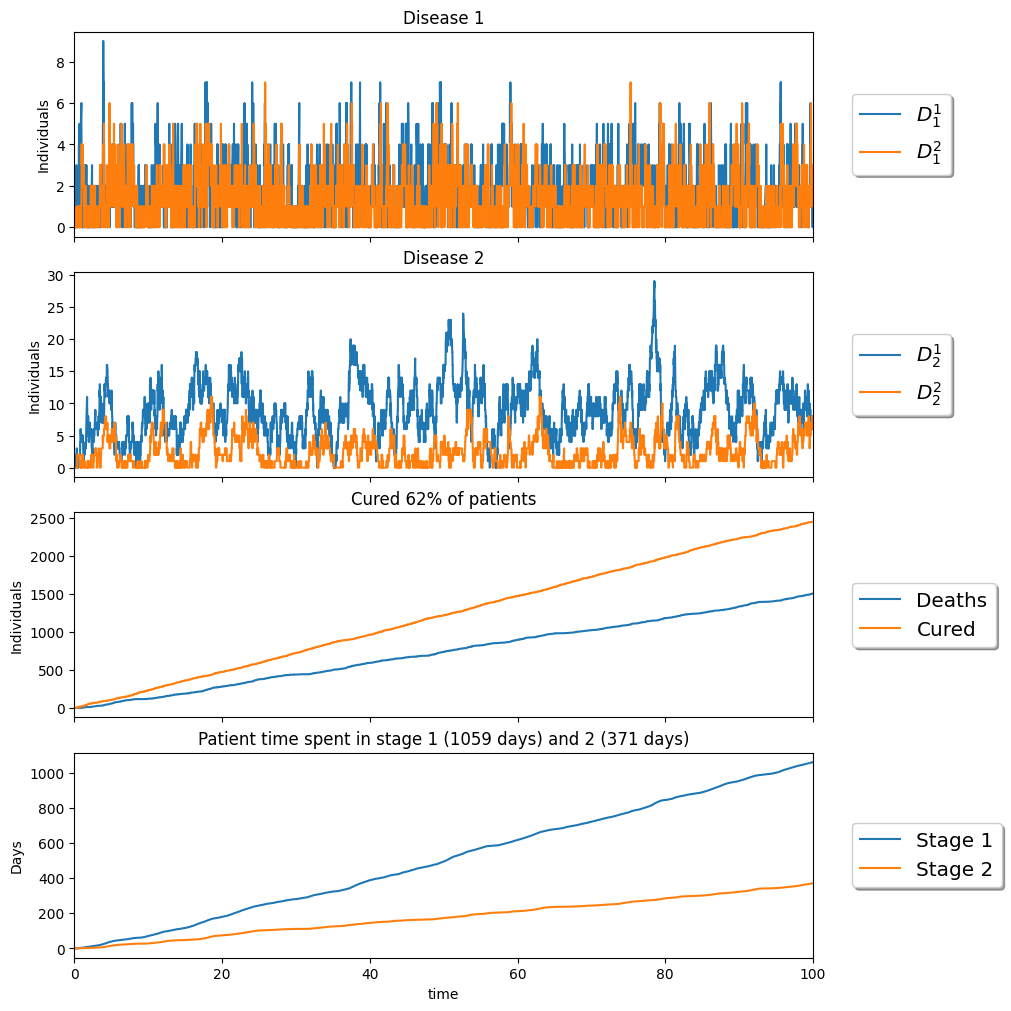

{'time_in_stage_1': 1058.7589958224462,
 'time_in_stage_2': 370.5467759222235,
 'deaths': 1506.0,
 'cured': 2452.0,
 'days_alive': array([     0.        ,      0.        ,      0.        , ...,
        123969.64161097, 123985.55284022, 124022.86086735])}

In [38]:
gillespie(I1_ratio  = 0.5, I2_ratio  = 0.5)

You could call the function simply by 
`gillespie()` or `gillespie(rWiseToRisky = 0.8)` if you want to chance the parameters / reaction rates.

But we can add interactivity by simply using `interact(function, paramters = (min, max, stepsize))`. And we get some lovely sliders.

_(Please, be patient and wait for updating of the graph.)_

In [27]:
interact(
    gillespie,
    lambda1   = (10, 30, 1),
    lambda2   = (10, 30, 1),
    r1_1      = (0.,10.,0.5), 
    r1_2      = (0.,10.,0.5),
    r2_1      = (0.,10.,0.5),
    r2_2      = (0.,10.,0.5),
    i1        = (0,20,1),
    i2        = (0,20,1),
    I1_ratio  = (0.,1.,0.1),
    I2_ratio  = (0.,1.,0.1)
)

interactive(children=(IntSlider(value=20, description='lambda1', max=30, min=10), IntSlider(value=20, descript…

<function __main__.gillespie(lambda1=20, lambda2=20, r1_1=10, r1_2=1, r2_1=10, r2_2=1, i1=15, i2=10, I1_ratio=0.5, I2_ratio=0.5, plot_bool=True)>

# Prioritising urgency

Here we explore three different policies for when disease 1 progresses at a far higher rate than disease 2, thus making the treatment more urgent.

In [55]:
ratios = [[0, 1], [1,9], [1,1], [9, 1], [1, 0]]
num_runs = 1000

for ratio in ratios:
    percent_cured_ratio = []
    times_in_stage_1 = []
    times_in_stage_2 = []
    days_alive = []
    for run in range(num_runs):
        output = gillespie(
            lambda1   = 1, 
            lambda2   = 1, 
            r1_1      = 10, 
            r1_2      = 0.1,
            r2_1      = 10,
            r2_2      = 0.1,
            i1        = 2,
            i2        = 0,
            I1_ratio  = ratio[0],
            I2_ratio  = ratio[1],
            plot_bool = False,
            max_treatments = 1
        )
        times_in_stage_1.append(output['time_in_stage_1'])
        times_in_stage_2.append(output['time_in_stage_2'])
        deaths = output['deaths']
        cured = output['cured']
        percent_cured_ratio.append(cured / (deaths + cured))
        #days_alive.append(output['days_alive'])
    print(ratio)
    print(f'time in stage 1: {np.mean(times_in_stage_1):.0f}')
    print(f'time in stage 2: {np.mean(times_in_stage_2):.0f}')
    #print(f'days alive: {np.mean(days_alive):.0f}')
    print(f'percent cured: {np.mean(percent_cured_ratio):.2f}\n')
    


[0, 1]
time in stage 1: 59
time in stage 2: 53
percent cured: 0.67

[1, 9]
time in stage 1: 59
time in stage 2: 55
percent cured: 0.66

[1, 1]
time in stage 1: 62
time in stage 2: 59
percent cured: 0.67

[9, 1]
time in stage 1: 66
time in stage 2: 61
percent cured: 0.68

[1, 0]
time in stage 1: 69
time in stage 2: 63
percent cured: 0.68



# Mass Action Kinetics

In [109]:
def mass_action(
      state, time, lambda1, lambda2, r1_1, r1_2, r2_1, r2_2,
      i1, i2, I1_ratio, I2_ratio):
    D1_1, D1_2, D2_1, D2_2, I1, I2, deaths, saved = state
    dD1_1 = lambda1 - r1_1 * D1_1 - 100 * I1_ratio * I1 * D1_1
    dD1_2 = lambda2 - r1_2 * D1_2 - 100 * I2_ratio * I1 * D1_2
    dD2_1 = r1_1 * D1_1 - r2_1 * D2_1 - 100 * I1_ratio * I2 * D2_1
    dD2_2 = r1_2 * D1_2 - r2_2 * D2_2 - 100 * I2_ratio * I2 * D2_2
    dI1 = i1 - 100 * I1_ratio * I1 * D1_1 - 100 * I2_ratio * I1 * D1_2
    dI2 = i2 - 100 * I1_ratio * I2 * D2_1 - 100 * I2_ratio * I2 * D2_2
    ddeaths = r2_1 * D2_1 + r2_2 * D2_2
    dsaved = 100 * (I1_ratio * I1 * D1_1 + I2_ratio * I1 * D1_2 + I1_ratio * I2 * D2_1 + I2_ratio * I2 * D2_2)
    return [dD1_1, dD1_2, dD2_1, dD2_2, dI1, dI2, ddeaths, dsaved]

initial_state = [0, 0, 0, 0, 0, 0, 0, 0]

t = np.linspace(0, 20, 101)

lambda1 = 20
lambda2 = 20
r1_1 = 10
r1_2 = 1
r2_1 = 10
r2_2 = 1
i1 = 15
i2 = 10
I1_ratio = 0.5
I2_ratio = 0.5

In [110]:
sol = odeint(mass_action, initial_state, t, args=(
    lambda1, lambda2, r1_1, r1_2, r2_1, r2_2,
      i1, i2, I1_ratio, I2_ratio))

final deaths: 287.45
final cured: 499.91


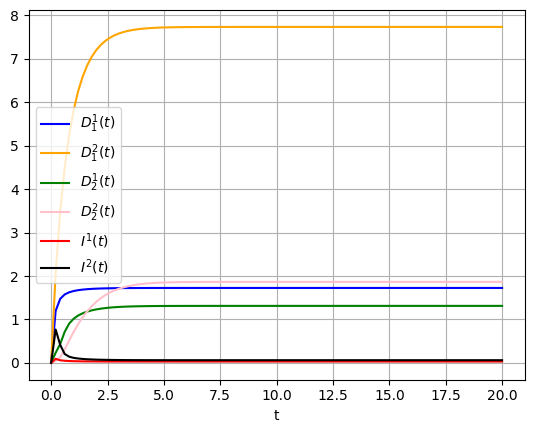

In [111]:
# sol = D1_1, D2_1, D1_2, D2_2, I1, I2, deaths, saved

plt.plot(t, sol[:, 0], 'b', label='$D^1_1(t)$')
plt.plot(t, sol[:, 1], 'orange', label='$D^2_1(t)$')
plt.plot(t, sol[:, 2], 'g', label='$D^1_2(t)$')
plt.plot(t, sol[:, 3], 'pink', label='$D^2_2(t)$')
plt.plot(t, sol[:, 4], 'r', label='$I^1(t)$')
plt.plot(t, sol[:, 5], 'black', label='$I^2(t)$')

print(f'final deaths: {sol[-1, 6]:.2f}')
print(f'final cured: {sol[-1, 7]:.2f}')

"""
plt.plot(t, sol[:, 2], 'r', label='Infected(t)')
plt.plot(t, sol[:, 3], 'black', label='Dead(t)')
plt.plot(t, sol[:, 4], 'g', label='Saved(t)')
"""
#plt.plot(t, sol[:, 2])
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [112]:
ratios = [[0.1,0.9], [0.5,0.5], [0.9, 0.1]]
for ratio in ratios:
    print(ratio)
    sol = odeint(mass_action, initial_state, t, args=(
    lambda1, lambda2, r1_1, r1_2, r2_1, r2_2,
      i1, i2, ratio[0], ratio[1]))
    deaths = sol[-1, 6]
    cured = sol[-1, 7]
    print(f'percent cured: {100 * cured / (cured + deaths):.2f}')


[0.1, 0.9]
percent cured: 63.18
[0.5, 0.5]
percent cured: 63.49
[0.9, 0.1]
percent cured: 64.21


# To Do
1. Policy rates need to be much higher
2. split cured, deaths by disease
3. add mass action equations
4. Total patient time spent with disease in stage 1, stage 2 etc.